In [ ]:
import pandas as pd

file_path = '/content/drive/MyDrive/Colab Notebooks/CDR_TrainingSet.PubTator.txt'

titles_data = []
abstracts_data = []
annotations_data = [] # New list for annotations

with open(file_path, 'r', encoding='utf-8') as f:
    for line in f:
        line = line.strip()
        if '|t|' in line:
            parts = line.split('|t|', 1)
            if len(parts) == 2:
                pmid = parts[0]
                title = parts[1]
                titles_data.append({'pmid': pmid, 'title': title})
        elif '|a|' in line:
            parts = line.split('|a|', 1)
            if len(parts) == 2:
                pmid = parts[0]
                abstract = parts[1]
                abstracts_data.append({'pmid': pmid, 'abstract': abstract})
        else: # Process lines that are not titles or abstracts as annotations
            parts = line.split('\t') # PubTator annotations are typically tab-separated
            if len(parts) >= 6: # Check if it has enough parts for an annotation
                pmid = parts[0]
                try:
                    start_offset = int(parts[1])
                    end_offset = int(parts[2])
                except ValueError: # Skip if offsets are not valid integers
                    continue
                text = parts[3]
                entity_type = parts[4]
                concept_id = parts[5]

                annotations_data.append({
                    'pmid': pmid,
                    'start_offset': start_offset,
                    'end_offset': end_offset,
                    'text': text,
                    'entity_type': entity_type,
                    'concept_id': concept_id
                })

titles_df = pd.DataFrame(titles_data)
abstracts_df = pd.DataFrame(abstracts_data)
annotations_df = pd.DataFrame(annotations_data) # New DataFrame for annotations

print("Titles DataFrame head:")
display(titles_df.head())

print("\nAbstracts DataFrame head:")
display(abstracts_df.head())

print("\nAnnotations DataFrame head (ignoring rows with |t| or |a|):")
display(annotations_df.head())

# Open AI processing

In [ ]:
pip install openai

In [ ]:
from openai import OpenAI

client = OpenAI(
  api_key="api-key"
)

response = client.responses.create(
  model="gpt-5-nano",
  input="write a haiku about ai",
  store=True,
)

print(response.output_text);


In [ ]:
def extract_drug_names(abstract_text):
    try:
        response = client.responses.create(
            model="gpt-5-nano",
            input=f"Extract all chemical and drug names from the following text and return them as a comma-separated list. If no chemical or drug names are found, return 'None'.\n\nText: {abstract_text}",
            store=True
        )
        return response.output_text.strip()
    except Exception as e:
        print(f"Error extracting names: {e}")
        return None

# Apply the function to the abstracts_df to create a new column
abstracts_df['extracted_drug_names'] = abstracts_df['abstract'].apply(extract_drug_names)

print("Abstracts DataFrame with extracted drug names:")
display(abstracts_df.head())

In [ ]:
titles_df.to_csv('/content/drive/MyDrive/Colab Notebooks/titles_data.csv', index=False)
abstracts_df.to_csv('/content/drive/MyDrive/Colab Notebooks/abstracts_data.csv', index=False)

print("DataFrames saved successfully as titles_data.csv and abstracts_data.csv")

In [ ]:
import pandas as pd

titles_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titles_data.csv')
abstracts_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/abstracts_data.csv')

print("Titles DataFrame head:")
display(titles_df.head())

print("\nAbstracts DataFrame head:")
display(abstracts_df.head())

In [ ]:
def extract_diseases(abstract_text):
    try:
        response = client.responses.create(
            model="gpt-5-nano",
            input=f"Extract all diseases and medical conditions from the following text and return them as a comma-separated list. If no diseases or medical conditions are found, return 'None'.\n\nText: {abstract_text}",
            store=True
        )
        return response.output_text.strip()
    except Exception as e:
        print(f"Error extracting diseases: {e}")
        return None

# Apply the function to the abstracts_df to create a new column
abstracts_df['extracted_diseases'] = abstracts_df['abstract'].apply(extract_diseases)

print("Abstracts DataFrame with extracted diseases:")
display(abstracts_df.head())

In [ ]:
def extract_relations(abstract_text, drugs_str, diseases_str):
    if drugs_str == 'None' or diseases_str == 'None' or not drugs_str or not diseases_str:
        return 'None'
    try:
        prompt = (
            f"Given the following abstract and lists of chemical/drug names and diseases, "
            f"identify all direct relationships between a drug and a disease mentioned in the abstract. "
            f"Return the relationships as a comma-separated list of tuples in the format (drug, disease, relation_type). "
            f"If no clear relation is found, return 'None'.\n\n"
            f"Abstract: {abstract_text}\n"
            f"Drugs: {drugs_str}\n"
            f"Diseases: {diseases_str}"
        )
        response = client.responses.create(
            model="gpt-5-nano",
            input=prompt,
            store=True
        )
        return response.output_text.strip()
    except Exception as e:
        print(f"Error extracting relations: {e}")
        return 'None'

# Apply the function to the abstracts_df to create a new column
abstracts_df['extracted_relations'] = abstracts_df.apply(
    lambda row: extract_relations(row['abstract'], row['extracted_drug_names'], row['extracted_diseases']),
    axis=1
)

print("Abstracts DataFrame with extracted relations:")
display(abstracts_df.head())

In [ ]:
titles_df.to_csv('/content/drive/MyDrive/Colab Notebooks/titles_data.csv', index=False)
abstracts_df.to_csv('/content/drive/MyDrive/Colab Notebooks/abstracts_data.csv', index=False)

print("DataFrames saved successfully as titles_data.csv and abstracts_data.csv")

In [ ]:
import pandas as pd

titles_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/titles_data.csv')
abstracts_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/abstracts_data.csv')

## CYPHER Generation Function


In [ ]:
import re
import pandas as pd # Import pandas to use pd.isna()

def escape_cypher_string(text):
    """Escapes single quotes in a string for use in CYPHER queries."""
    return text.replace("'", "\\'")

def generate_cypher_queries(pmid, drugs_str, diseases_str, relations_str):
    cypher_queries = []
    unique_drugs = set()
    unique_diseases = set()

    # Handle potential NaN values by converting them to empty strings
    drugs_str = '' if pd.isna(drugs_str) else str(drugs_str)
    diseases_str = '' if pd.isna(diseases_str) else str(diseases_str)
    relations_str = '' if pd.isna(relations_str) else str(relations_str)

    # Process Drug Names
    if drugs_str and drugs_str != 'None':
        drug_names = [name.strip() for name in drugs_str.split(',') if name.strip()]
        for drug_name in drug_names:
            if drug_name not in unique_drugs:
                unique_drugs.add(drug_name)
                escaped_drug_name = escape_cypher_string(drug_name)
                cypher_queries.append(f"MERGE (:Drug {{name: '{escaped_drug_name}'}})")

    # Process Disease Names
    if diseases_str and diseases_str != 'None':
        disease_names = [name.strip() for name in diseases_str.split(',') if name.strip()]
        for disease_name in disease_names:
            if disease_name not in unique_diseases:
                unique_diseases.add(disease_name)
                escaped_disease_name = escape_cypher_string(disease_name)
                cypher_queries.append(f"MERGE (:Disease {{name: '{escaped_disease_name}'}})")

    # Process Relationships
    if relations_str and relations_str != 'None':
        # Use regex to find all tuples within the string
        relation_tuples_str = re.findall(r'\(([^)]*)\)', relations_str)

        for rel_tuple_str in relation_tuples_str:
            parts = [part.strip() for part in rel_tuple_str.split(',')]
            if len(parts) == 3:
                drug = parts[0]
                disease = parts[1]
                relation_type = parts[2]

                escaped_drug = escape_cypher_string(drug)
                escaped_disease = escape_cypher_string(disease)
                escaped_relation_type = escape_cypher_string(relation_type)
                escaped_pmid = escape_cypher_string(str(pmid))

                # Ensure drug and disease nodes exist before creating relationship
                cypher_queries.append(
                    f"MERGE (d:Drug {{name: '{escaped_drug}'}}) "
                    f"MERGE (s:Disease {{name: '{escaped_disease}'}}) "
                    f"MERGE (d)-[:HAS_RELATION {{pmid: '{escaped_pmid}', type: '{escaped_relation_type}'}}]->(s)"
                )
    return cypher_queries

In [ ]:
abstracts_df['cypher_queries'] = abstracts_df.apply(
    lambda row: generate_cypher_queries(
        row['pmid'],
        row['extracted_drug_names'],
        row['extracted_diseases'],
        row['extracted_relations']
    ),
    axis=1
)

print("Abstracts DataFrame with generated CYPHER queries:")
display(abstracts_df.head())

print("\nExample CYPHER queries from the first few rows:")
for i, queries in enumerate(abstracts_df['cypher_queries'].head(3)):
    print(f"\n--- Row {i+1} ---")
    for query in queries:
        print(query)

# Neo4j Execution

In [ ]:
pip install neo4j

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 325.4/325.4 kB 4.7 MB/s eta 0:00:00


In [ ]:
from neo4j import GraphDatabase

# Replace with your Neo4j instance's URI, username, and password
URI = "URI"
AUTH = ("user", "password")

class Neo4jConnection:
    def __init__(self, uri, user, password):
        self._driver = GraphDatabase.driver(uri, auth=(user, password))

    def close(self):
        self._driver.close()

    def query(self, query, parameters=None, db=None):
        with self._driver.session(database=db) as session:
            result = session.run(query, parameters)
            return list(result) # Fetch all records before the session closes

In [ ]:
driver = Neo4jConnection(URI, AUTH[0], AUTH[1])

query_count = 0
for index, row in abstracts_df.iterrows():
    queries = row['cypher_queries']
    if queries:
        for query_statement in queries:
            try:
                driver.query(query_statement)
                query_count += 1
            except Exception as e:
                print(f"Error executing query: {query_statement}\nError: {e}")

driver.close()
print(f"Successfully executed {query_count} CYPHER queries to Neo4j.")

In [ ]:
import pandas as pd

# 1. Extract unique drug names from abstracts_df
all_extracted_drugs = set()
for drugs_str in abstracts_df['extracted_drug_names']:
    if pd.notna(drugs_str) and drugs_str != 'None' and drugs_str != '':
        for drug in drugs_str.split(','):
            all_extracted_drugs.add(drug.strip())

# 2. Extract unique disease names from abstracts_df
all_extracted_diseases = set()
for diseases_str in abstracts_df['extracted_diseases']:
    if pd.notna(diseases_str) and diseases_str != 'None' and diseases_str != '':
        for disease in diseases_str.split(','):
            all_extracted_diseases.add(disease.strip())

# Combine all extracted entities from abstracts_df
all_abstracts_entities = all_extracted_drugs.union(all_extracted_diseases)

# 3. Extract unique text from annotations_df
all_annotations_text = set(annotations_df['text'].unique())

print(f"Total unique extracted drugs from abstracts_df: {len(all_extracted_drugs)}")
print(f"Total unique extracted diseases from abstracts_df: {len(all_extracted_diseases)}")
print(f"Total unique entities (drugs + diseases) from abstracts_df: {len(all_abstracts_entities)}")
print(f"Total unique texts from annotations_df: {len(all_annotations_text)}")

# 4. Compare and count mismatches
# Entities in abstracts_df that are NOT in annotations_df
not_in_annotations = all_abstracts_entities - all_annotations_text
print(f"\nNumber of entities from abstracts_df (drugs/diseases) NOT found in annotations_df['text']: {len(not_in_annotations)}")
# print(f"Examples of entities not in annotations_df: {list(not_in_annotations)[:10]}") # Uncomment to see examples

# Entities in annotations_df that are NOT in abstracts_df (drugs/diseases)
not_in_abstracts_extracted = all_annotations_text - all_abstracts_entities
print(f"Number of entities from annotations_df['text'] NOT found in abstracts_df (drugs/diseases): {len(not_in_abstracts_extracted)}")
# print(f"Examples of entities not in abstracts_df extracted: {list(not_in_abstracts_extracted)[:10]}") # Uncomment to see examples


## Random Nodes

In [ ]:
num_random_nodes = 20 # Define how many random nodes to fetch

# Cypher query to get a random selection of nodes
query_random_nodes = f"MATCH (n) RETURN n SKIP toInteger(rand() * 1000) LIMIT {num_random_nodes}"

# Always create a new connection for this operation, as the previous one was explicitly closed.
# This avoids issues with checking the state of a potentially closed or invalid driver object.
driver = Neo4jConnection(URI, AUTH[0], AUTH[1])

try:
    print(f"Fetching {num_random_nodes} random nodes from Neo4j...")
    results = driver.query(query_random_nodes)

    print("\nRandom Nodes:")
    for record in results:
        node = record["n"]
        print(f"ID: {node.element_id}, Labels: {list(node.labels)}, Properties: {dict(node)}")

finally:
    # Ensure the driver is closed after use
    driver.close()

Fetching 20 random nodes from Neo4j...

Random Nodes:
ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:799, Labels: ['Drug'], Properties: {'name': 'AVP'}
ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:800, Labels: ['Drug'], Properties: {'name': 'Li'}
ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:801, Labels: ['Drug'], Properties: {'name': 'LiCl'}
ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:802, Labels: ['Disease'], Properties: {'name': 'diabetes insipidus'}
ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:803, Labels: ['Disease'], Properties: {'name': 'dehydration'}
ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:804, Labels: ['Drug'], Properties: {'name': 'suxamethonium'}
ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:805, Labels: ['Disease'], Properties: {'name': 'cardiac arrest'}
ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:806, Labels: ['Disease'], Properties: {'name': 'hyperkalaemia'}
ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:807, Labels: ['Disease'], Properties: {'name': 'meningitis'}
ID: 4:e29299a3-2702-41c6

## Implement `perform_random_walk` function

In [ ]:
import random

def perform_random_walk(driver, node_element_id, walk_length, relationship_type=None):
    """
    Performs a random walk starting from a given node in the Neo4j graph.

    Args:
        driver (Neo4jConnection): An instance of the Neo4jConnection class.
        node_element_id (str): The element ID of the starting node.
        walk_length (int): The maximum length of the walk.
        relationship_type (str, optional): Constrain the relationships to this type.
                                           Defaults to None, meaning any relationship type.

    Returns:
        list: A list of records containing the nodes and relationships of the random walk path.
    """
    # Ensure walk_length is at least 1
    if walk_length < 1:
        raise ValueError("walk_length must be a positive integer")

    # Construct the relationship part of the query
    if relationship_type:
        rel_pattern = f"-[:`{relationship_type}`*1..{walk_length}]-"
    else:
        rel_pattern = f"-[r*1..{walk_length}]-"

    # Cypher query to perform a random walk
    # START n=node({node_element_id}) is deprecated, use MATCH (n) WHERE elementId(n) = ...
    query = f"""
    MATCH (n)
    WHERE elementId(n) = $node_element_id
    MATCH p = (n){rel_pattern}(m)
    RETURN relationships(p) AS relationships, nodes(p) AS nodes
    ORDER BY rand()
    LIMIT 1
    """

    # Parameters for the query
    params = {
        "node_element_id": node_element_id
    }

    try:
        # Execute the query
        results = driver.query(query, params)
        return results
    except Exception as e:
        print(f"Error performing random walk from {node_element_id}: {e}")
        return []

print("Defined the perform_random_walk function.")


Defined the perform_random_walk function.


In [ ]:
print("\nPerforming random walks for the fetched nodes...")

# Re-initialize the driver as it was closed in the previous step
driver = Neo4jConnection(URI, AUTH[0], AUTH[1])

walk_length = 3 # Define a suitable walk length

try:
    for record in results:
        node = record["n"]
        node_id = node.element_id
        node_properties = dict(node)
        node_labels = list(node.labels)

        print(f"\n--- Starting Random Walk from Node ---")
        print(f"  Start Node ID: {node_id}")
        print(f"  Start Node Labels: {node_labels}")
        print(f"  Start Node Properties: {node_properties}")

        # Perform a random walk without specifying a relationship type
        walk_results = perform_random_walk(driver, node_id, walk_length)

        if walk_results:
            for walk_record in walk_results:
                walk_nodes = walk_record["nodes"]
                walk_relationships = walk_record["relationships"]

                print(f"  Walk Path (length up to {walk_length}):")
                path_description = []
                for i in range(len(walk_nodes)):
                    current_node = walk_nodes[i]
                    path_description.append(f"({dict(current_node).get('name', current_node.element_id)})[{', '.join(list(current_node.labels))}]")
                    if i < len(walk_relationships):
                        rel = walk_relationships[i]
                        path_description.append(f"-[{dict(rel).get('type', rel.type)}]->")
                print("    " + "".join(path_description))

        else:
            print(f"  No random walk found of length up to {walk_length} from this node.")
finally:
    driver.close() # Close the driver after all operations are complete
print("\nNeo4j connection closed.")


Performing random walks for the fetched nodes...

--- Starting Random Walk from Node ---
  Start Node ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:799
  Start Node Labels: ['Drug']
  Start Node Properties: {'name': 'AVP'}
  No random walk found of length up to 3 from this node.

--- Starting Random Walk from Node ---
  Start Node ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:800
  Start Node Labels: ['Drug']
  Start Node Properties: {'name': 'Li'}
  No random walk found of length up to 3 from this node.

--- Starting Random Walk from Node ---
  Start Node ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:801
  Start Node Labels: ['Drug']
  Start Node Properties: {'name': 'LiCl'}
  Walk Path (length up to 3):
    (LiCl)[Drug]-[causes]->(polyuria)[Disease]-[associated_with]->(lithium)[Drug]

--- Starting Random Walk from Node ---
  Start Node ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:802
  Start Node Labels: ['Disease']
  Start Node Properties: {'name': 'diabetes insipidus'}
  Walk Path (length up

In [ ]:
import random
from neo4j import GraphDatabase

# Helper function to get a random next node and its relation type
def get_random_next_node_and_relation(driver, current_node_element_id):
    """
    Finds all direct outgoing neighbors from a given node and returns one randomly selected.
    Returns (next_node_element_id, next_node_labels, next_node_properties, relationship_type).
    """
    query = """
    MATCH (n)-[r]->(m)
    WHERE elementId(n) = $node_element_id
    RETURN elementId(m) AS next_node_id, labels(m) AS next_node_labels, properties(m) AS next_node_properties, type(r) AS rel_type
    """
    params = {"node_element_id": current_node_element_id}
    try:
        results = driver.query(query, params)
        if results:
            # Select one random result from the outgoing neighbors
            random_result = random.choice(results)
            return (
                random_result["next_node_id"],
                random_result["next_node_labels"],
                random_result["next_node_properties"],
                random_result["rel_type"]
            )
        else:
            return None, None, None, None # No outgoing relationships
    except Exception as e:
        print(f"Error getting random next node from {current_node_element_id}: {e}")
        return None, None, None, None


def perform_markov_chain(driver, start_node_element_id, num_steps):
    """
    Performs a Markov chain simulation starting from a given node.

    Args:
        driver (Neo4jConnection): An instance of the Neo4jConnection class.
        start_node_element_id (str): The element ID of the starting node.
        num_steps (int): The number of transitions (steps) in the Markov chain.

    Returns:
        list: A list of dictionaries, where each dictionary represents a step in the path
              and contains 'node_id', 'node_labels', 'node_properties', and 'rel_type_from_prev'.
              The first node in the path will have 'rel_type_from_prev' as None.
    """
    path = []
    current_node_id = start_node_element_id

    # Get initial node details to add to path
    initial_node_query = "MATCH (n) WHERE elementId(n) = $node_element_id RETURN labels(n) AS node_labels, properties(n) AS node_properties"
    initial_node_params = {"node_element_id": start_node_element_id}
    initial_node_result = driver.query(initial_node_query, initial_node_params)
    if initial_node_result:
        initial_node_data = initial_node_result[0]
        path.append({
            'node_id': start_node_element_id,
            'node_labels': initial_node_data['node_labels'],
            'node_properties': initial_node_data['node_properties'],
            'rel_type_from_prev': None # Starting node has no previous relation
        })
    else:
        print(f"Start node {start_node_element_id} not found.")
        return []

    for _ in range(num_steps):
        next_node_id, next_node_labels, next_node_properties, rel_type = get_random_next_node_and_relation(driver, current_node_id)
        if next_node_id:
            path.append({
                'node_id': next_node_id,
                'node_labels': next_node_labels,
                'node_properties': next_node_properties,
                'rel_type_from_prev': rel_type
            })
            current_node_id = next_node_id
        else:
            # No outgoing relationships from current_node_id, chain ends
            break
    return path

print("Defined functions for Markov chain transitions.")

Defined functions for Markov chain transitions.


In [ ]:
# Re-initialize the driver as it might have been closed
driver = Neo4jConnection(URI, AUTH[0], AUTH[1])

# Choose a starting node (e.g., the first one from the 'results' list)
if results:
    start_node_record = results[3]
    start_node = start_node_record["n"]
    start_node_element_id = start_node.element_id
    start_node_properties = dict(start_node)
    start_node_labels = list(start_node.labels)

    num_steps = 5 # Define the number of steps for the Markov chain

    print(f"\n--- Performing Markov Chain from Node ---")
    print(f"  Start Node ID: {start_node_element_id}")
    print(f"  Start Node Labels: {start_node_labels}")
    print(f"  Start Node Properties: {start_node_properties}")

    try:
        markov_path = perform_markov_chain(driver, start_node_element_id, num_steps)

        if markov_path:
            print(f"  Markov Chain Path (length {num_steps} steps):")
            for i, step in enumerate(markov_path):
                node_props = step['node_properties']
                node_name = node_props.get('name', step['node_id'])
                node_labels_str = ', '.join(step['node_labels'])
                rel_info = f"-[{step['rel_type_from_prev']}]->" if step['rel_type_from_prev'] else ''
                print(f"    Step {i}: {rel_info}({node_name})[{node_labels_str}] (ID: {step['node_id']})")
        else:
            print("  No Markov chain path found or the chain ended early.")

    except Exception as e:
        print(f"Error during Markov chain execution: {e}")
    finally:
        driver.close() # Ensure the driver is closed even if an error occurs
else:
    driver.close() # Close driver if there are no results to process

print("\nNeo4j connection closed.")


--- Performing Markov Chain from Node ---
  Start Node ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:802
  Start Node Labels: ['Disease']
  Start Node Properties: {'name': 'diabetes insipidus'}
  Markov Chain Path (length 5 steps):
    Step 0: (diabetes insipidus)[Disease] (ID: 4:e29299a3-2702-41c6-9df7-2836a78175df:802)

Neo4j connection closed.


## Jaccard Similarity Query

In [ ]:
import pandas as pd

# Re-initialize the driver
driver = Neo4jConnection(URI, AUTH[0], AUTH[1])

# Cypher query to calculate Jaccard Similarity
jaccard_query = """
MATCH (d1:Drug)-[:HAS_RELATION]->(dis:Disease)<-[:HAS_RELATION]-(d2:Drug)
WHERE elementId(d1) < elementId(d2)
WITH d1, d2, count(DISTINCT dis) AS intersection
MATCH (d1)-[:HAS_RELATION]->(d1_dis:Disease)
WITH d1, d2, intersection, count(DISTINCT d1_dis) AS d1_count
MATCH (d2)-[:HAS_RELATION]->(d2_dis:Disease)
WITH d1, d2, intersection, d1_count, count(DISTINCT d2_dis) AS d2_count
WITH d1, d2, intersection, (d1_count + d2_count - intersection) AS union_size
RETURN d1.name AS Drug1, d2.name AS Drug2, intersection AS Intersection, union_size AS Union, toFloat(intersection)/union_size AS JaccardIndex
ORDER BY JaccardIndex DESC
LIMIT 20
"""

try:
    print("Calculating Jaccard Similarity between drugs based on shared diseases...")
    results = driver.query(jaccard_query)

    if results:
        # Convert results to a DataFrame for display
        df_jaccard = pd.DataFrame([dict(record) for record in results])
        print("\nTop 20 Drug Pairs by Jaccard Similarity:")
        display(df_jaccard)
    else:
        print("No results found. Ensure there are drugs sharing diseases in the graph.")

except Exception as e:
    print(f"Error executing Jaccard Similarity query: {e}")

finally:
    driver.close()
    print("\nNeo4j connection closed.")

Calculating Jaccard Similarity between drugs based on shared diseases...

Top 20 Drug Pairs by Jaccard Similarity:


,Drug1,Drug2,Intersection,Union,JaccardIndex
0,Actomycin-D,Cisplatin,1,1,1.0
1,noradrenaline,hydrochlorothiazide,1,1,1.0
2,Methotrexate,Actomycin-D,1,1,1.0
3,Cyclophosphamide,Cisplatin,1,1,1.0
4,Carbetmazepine,Propylene glycol,1,1,1.0
5,dothiepin,amitriptyline,2,2,1.0
6,Etoposide,Cyclophosphamide,1,1,1.0
7,Etoposide,Actomycin-D,1,1,1.0
8,Etoposide,Cisplatin,1,1,1.0
9,Methotrexate,Cisplatin,1,1,1.0



Neo4j connection closed.


## Define Metrics Calculation Function


In [ ]:
def calculate_walk_metrics(walk_nodes, walk_relationships):
    """
    Calculates metrics for a given random walk path.

    Args:
        walk_nodes (list): A list of Neo4j node objects in the walk.
        walk_relationships (list): A list of Neo4j relationship objects in the walk.

    Returns:
        dict: A dictionary containing the computed metrics.
    """
    # 1. Number of unique nodes visited
    unique_node_ids = set()
    for node in walk_nodes:
        unique_node_ids.add(node.element_id)
    num_unique_nodes = len(unique_node_ids)

    # 2. Actual path length (number of relationships)
    actual_path_length = len(walk_relationships)

    # 3. Distribution of node labels
    label_distribution = {'Drug': 0, 'Disease': 0}
    for node in walk_nodes:
        if 'Drug' in node.labels:
            label_distribution['Drug'] += 1
        if 'Disease' in node.labels:
            label_distribution['Disease'] += 1

    return {
        'num_unique_nodes': num_unique_nodes,
        'actual_path_length': actual_path_length,
        'label_distribution': label_distribution
    }

print("Defined the calculate_walk_metrics function.")

Defined the calculate_walk_metrics function.


## Perform Multiple Random Walks and Collect Metrics

In [ ]:
import pandas as pd

# 1. Re-initialize the Neo4jConnection driver
driver = Neo4jConnection(URI, AUTH[0], AUTH[1])

# 2. Create an empty list named all_walk_metrics
all_walk_metrics = []

# 3. Define the number of random walks to perform for each starting node
num_walks_per_node = 10

# 4. Define the length of each random walk
walk_length = 3

try:
    # Re-fetch random nodes, as the 'results' variable was overwritten
    # (Using query_random_nodes and num_random_nodes from earlier in the notebook)
    query_random_nodes = f"MATCH (n) RETURN n SKIP toInteger(rand() * 1000) LIMIT {num_random_nodes}"
    random_nodes_for_walks = driver.query(query_random_nodes)

    # 5. Iterate through each record in the random_nodes_for_walks list
    for record in random_nodes_for_walks:
        node = record["n"]
        # 6. For each node, extract its element_id
        node_element_id = node.element_id

        # 7. Implement a nested loop to perform num_walks_per_node random walks
        for _ in range(num_walks_per_node):
            # a. Call the perform_random_walk function
            walk_results = perform_random_walk(driver, node_element_id, walk_length)

            # b. Check if walk_results is not empty
            if walk_results:
                # c. Extract nodes and relationships from the first walk record
                first_walk_record = walk_results[0]
                walk_nodes = first_walk_record["nodes"]
                walk_relationships = first_walk_record["relationships"]

                # d. Call the calculate_walk_metrics function
                metrics = calculate_walk_metrics(walk_nodes, walk_relationships)

                # e. Store the metrics along with the start_node_element_id
                metrics['start_node_id'] = node_element_id
                metrics['start_node_labels'] = list(node.labels)
                metrics['start_node_name'] = node.get('name') # Assuming 'name' property exists
                all_walk_metrics.append(metrics)

finally:
    # 10. Ensure the driver is closed
    driver.close()

# 8. Convert the all_walk_metrics list into a pandas DataFrame
df_walk_metrics = pd.DataFrame(all_walk_metrics)

# 9. Print the head of the DataFrame
print("DataFrame of Random Walk Metrics:")
display(df_walk_metrics.head())

DataFrame of Random Walk Metrics:


,num_unique_nodes,actual_path_length,label_distribution,start_node_id,start_node_labels,start_node_name
0,3,2,"{'Drug': 2, 'Disease': 1}",4:e29299a3-2702-41c6-9df7-2836a78175df:321,[Drug],nicotine sulfate
1,4,3,"{'Drug': 2, 'Disease': 2}",4:e29299a3-2702-41c6-9df7-2836a78175df:321,[Drug],nicotine sulfate
2,3,2,"{'Drug': 2, 'Disease': 1}",4:e29299a3-2702-41c6-9df7-2836a78175df:321,[Drug],nicotine sulfate
3,2,1,"{'Drug': 1, 'Disease': 1}",4:e29299a3-2702-41c6-9df7-2836a78175df:321,[Drug],nicotine sulfate
4,2,1,"{'Drug': 1, 'Disease': 1}",4:e29299a3-2702-41c6-9df7-2836a78175df:321,[Drug],nicotine sulfate


## Analyze and Display Aggregated Walk Metrics



In [ ]:
print("\n--- Aggregated Walk Metrics ---")

# 1. Calculate the average of 'num_unique_nodes' and 'actual_path_length'
average_unique_nodes = df_walk_metrics['num_unique_nodes'].mean()
average_path_length = df_walk_metrics['actual_path_length'].mean()

# 2. Initialize counters for the total number of 'Drug' and 'Disease' nodes
total_drug_nodes = 0
total_disease_nodes = 0

# 3. Iterate through the 'label_distribution' column to sum up counts
for distribution in df_walk_metrics['label_distribution']:
    total_drug_nodes += distribution.get('Drug', 0)
    total_disease_nodes += distribution.get('Disease', 0)

# 4. Print the calculated aggregated metrics
print(f"Average Number of Unique Nodes Visited: {average_unique_nodes:.2f}")
print(f"Average Actual Path Length: {average_path_length:.2f}")
print(f"Total 'Drug' Nodes Encountered Across All Walks: {total_drug_nodes}")
print(f"Total 'Disease' Nodes Encountered Across All Walks: {total_disease_nodes}")


--- Aggregated Walk Metrics ---
Average Number of Unique Nodes Visited: 3.18
Average Actual Path Length: 2.27
Total 'Drug' Nodes Encountered Across All Walks: 248
Total 'Disease' Nodes Encountered Across All Walks: 243


## Visualize Node Type Distribution


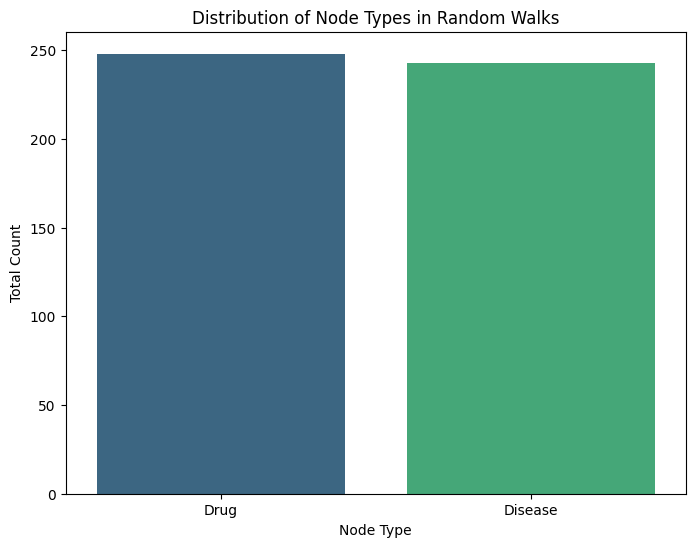

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a dictionary to hold the total counts
node_type_counts = {
    'Drug': total_drug_nodes,
    'Disease': total_disease_nodes
}

# Convert to a pandas Series for easy plotting
node_type_series = pd.Series(node_type_counts)

# Create the bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=node_type_series.index, y=node_type_series.values, hue=node_type_series.index, palette='viridis', legend=False)

# Add labels and title
plt.xlabel('Node Type')
plt.ylabel('Total Count')
plt.title('Distribution of Node Types in Random Walks')

# Display the plot
plt.show()

## Traverse based on relevance


In [ ]:
import pandas as pd
from neo4j import GraphDatabase

# Re-initialize the driver (assuming it was closed previously)
driver = Neo4jConnection(URI, AUTH[0], AUTH[1])

# Extract element IDs from the 'random_nodes_for_walks' variable (random nodes fetched earlier)
# 'results' was overwritten by the Jaccard Similarity query.
random_node_element_ids = [record["n"].element_id for record in random_nodes_for_walks]

# Cypher query to traverse the graph based on relevance and log frequency of visits.
# "Relevance" is interpreted as paths of length 1 to 3 between Drug and Disease nodes.
# "Frequency of visits" is the count of how many times each distinct node label and
# relationship type appears across all such relevant paths.
# The query now includes a filter to ensure paths involve at least one of the random nodes.
cypher_query = """
MATCH path = (start_node)-[rels:HAS_RELATION*1..8]->(end_node)
WHERE ((start_node:Drug AND end_node:Disease) OR (start_node:Disease AND end_node:Drug))
      AND any(node_in_path IN nodes(path) WHERE elementId(node_in_path) IN $randomNodeElementIds)
WITH path
LIMIT 10000 // Limit the number of paths to avoid excessive memory usage for very dense graphs

// Aggregate node labels and count their frequencies
UNWIND nodes(path) AS node_in_path
UNWIND labels(node_in_path) AS label
RETURN 'Node Label' AS Category, label AS Item, count(label) AS Frequency

UNION ALL

MATCH path = (start_node)-[rels:HAS_RELATION*1..8]->(end_node)
WHERE ((start_node:Drug AND end_node:Disease) OR (start_node:Disease AND end_node:Drug))
      AND any(node_in_path IN nodes(path) WHERE elementId(node_in_path) IN $randomNodeElementIds)
WITH path
LIMIT 10000 // Repeat limit for the second part of UNION ALL

// Aggregate relationship types and count their frequencies
UNWIND relationships(path) AS rel_in_path
RETURN 'Relationship Type' AS Category, type(rel_in_path) AS Item, count(type(rel_in_path)) AS Frequency
ORDER BY Frequency DESC
"""

try:
    print("Executing Cypher query for relevance-based traversal and frequency logging...")
    # Pass the random node element IDs as a parameter to the query
    results = driver.query(cypher_query, parameters={"randomNodeElementIds": random_node_element_ids})

    if results:
        df_frequency = pd.DataFrame([dict(record) for record in results])
        print("\nFrequency of Node Labels and Relationship Types in Relevant Paths:")
        display(df_frequency)
    else:
        print("No relevant paths found or no data to count.")

except Exception as e:
    print(f"Error executing relevance-based traversal query: {e}")

finally:
    driver.close()
    print("\nNeo4j connection closed.")

Executing Cypher query for relevance-based traversal and frequency logging...

Frequency of Node Labels and Relationship Types in Relevant Paths:


,Category,Item,Frequency
0,Node Label,Drug,46
1,Node Label,Disease,46
2,Relationship Type,HAS_RELATION,46



Neo4j connection closed.


In [ ]:
import pandas as pd
from neo4j import GraphDatabase

# Re-initialize the driver (assuming it was closed previously)
driver = Neo4jConnection(URI, AUTH[0], AUTH[1])

# Extract element IDs from the 'random_nodes_for_walks' variable (random nodes fetched earlier)
random_node_element_ids = [record["n"].element_id for record in random_nodes_for_walks]

# Cypher query to traverse the graph based on relevance and log frequency of visits.
# "Relevance" is interpreted as paths of length 1 to k between Drug and Disease nodes.
# "Frequency of visits" is the count of how many times each distinct node label and
# relationship type appears across all such relevant paths.
# The query now includes a filter to ensure paths involve at least one of the random nodes.
cypher_query = """
MATCH path = (start_node)-[rels:HAS_RELATION*1..8]->(end_node)
WHERE ((start_node:Drug AND end_node:Disease) OR (start_node:Disease AND end_node:Drug))
      AND any(node_in_path IN nodes(path) WHERE elementId(node_in_path) IN $randomNodeElementIds)
WITH path
LIMIT 10000 // Limit the number of paths to avoid excessive memory usage for very dense graphs

// Aggregate node names and count their frequencies for Drug/Disease nodes
UNWIND nodes(path) AS node_in_path
WITH node_in_path // Bring node_in_path into scope for filtering and aggregation
WHERE (node_in_path:Drug OR node_in_path:Disease) AND node_in_path.name IS NOT NULL
WITH 'Node Name' AS Category, node_in_path.name AS Item
RETURN Category, Item, count(Item) AS Frequency

UNION ALL

MATCH path = (start_node)-[rels:HAS_RELATION*1..8]->(end_node)
WHERE ((start_node:Drug AND end_node:Disease) OR (start_node:Disease AND end_node:Drug))
      AND any(node_in_path IN nodes(path) WHERE elementId(node_in_path) IN $randomNodeElementIds)
WITH path
LIMIT 10000 // Repeat limit for the second part of UNION ALL

// Aggregate relationship types and count their frequencies based on their 'type' property
UNWIND relationships(path) AS rel_in_path
WITH 'Relationship Type' AS Category, rel_in_path.type AS Item // Extract the 'type' property
WHERE Item IS NOT NULL // Ensure the 'type' property exists
RETURN Category, Item, count(Item) AS Frequency
ORDER BY Frequency DESC
"""

try:
    print("Executing Cypher query for relevance-based traversal and frequency logging...")
    # Pass the random node element IDs as a parameter to the query
    results = driver.query(cypher_query, parameters={"randomNodeElementIds": random_node_element_ids})

    if results:
        df_frequency = pd.DataFrame([dict(record) for record in results])
        print("\nFrequency of Node Labels and Relationship Types in Relevant Paths:")
        display(df_frequency)
    else:
        print("No relevant paths found or no data to count.")

except Exception as e:
    print(f"Error executing relevance-based traversal query: {e}")

finally:
    driver.close()
    print("\nNeo4j connection closed.")

Executing Cypher query for relevance-based traversal and frequency logging...

Frequency of Node Labels and Relationship Types in Relevant Paths:


,Category,Item,Frequency
0,Node Name,isoflurane,1
1,Node Name,hypotension,4
2,Node Name,trimethaphan,1
3,Node Name,prostaglandin E1,4
4,Node Name,pilocarpine,13
5,Node Name,seizures,4
6,Node Name,impotence,1
7,Node Name,Coniine,2
8,Node Name,arthrogryposis,1
9,Node Name,nicotine sulfate,2



Neo4j connection closed.
